## Analiza danych

#### Przegląd atrybutów z *listings*

In [1]:
%load_ext autoreload
%autoreload 2

import sys
from pathlib import Path

sys.path.append(str(Path("..").resolve()))

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

listings = pd.read_csv("../data/raw/listings.csv")
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 75 columns):
 #   Column                                        Non-Null Count  Dtype  
---  ------                                        --------------  -----  
 0   id                                            1458 non-null   int64  
 1   listing_url                                   1458 non-null   object 
 2   scrape_id                                     1458 non-null   int64  
 3   last_scraped                                  1458 non-null   object 
 4   source                                        1458 non-null   object 
 5   name                                          1458 non-null   object 
 6   description                                   1433 non-null   object 
 7   neighborhood_overview                         726 non-null    object 
 8   picture_url                                   1458 non-null   object 
 9   host_id                                       1458 non-null   i

#### Wybór atrybutów 
Do obliczenia przewidywanej ceny wymagane są przede wszystkim kolumny definiujące standard kwatery. 
Atrybuty związane z dostępnością, cechami gospodarza lub opiniami użytkowników mogą także mieć wpływ na zmienną objaśnianą, dlatego póki co nie zostają usunięte (jeśli późniejsza analiza wskaże, że są wtórne zostaną wykluczone). Dodatkowo można pozbyć się kolumn zawierających metadane, ponieważ są one całkowicie nieinformatywne.

Lista wybranych początkowo atrybutów znajduje się w pliku *features.py*, a zastosowanych transformacji w *transformations/listings.py*.

In [3]:
from src.transformations.features import INITIAL_FEATURES,TARGET
from src.transformations.listings import *

target = listings[TARGET]
listings = listings[INITIAL_FEATURES]
listings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 23 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           1458 non-null   object 
 1   room_type               1458 non-null   object 
 2   accommodates            1458 non-null   int64  
 3   bathrooms               1369 non-null   float64
 4   bathrooms_text          1456 non-null   object 
 5   bedrooms                1446 non-null   float64
 6   beds                    1370 non-null   float64
 7   amenities               1458 non-null   object 
 8   description             1433 non-null   object 
 9   neighborhood_overview   726 non-null    object 
 10  latitude                1458 non-null   float64
 11  longitude               1458 non-null   float64
 12  host_response_time      1276 non-null   object 
 13  host_response_rate      1276 non-null   object 
 14  host_acceptance_rate    1370 non-null   

#### Atrybuty nienumeryczne

In [4]:
object_columns = listings.select_dtypes(include=["object"]).columns
for col in object_columns:
    print(f"{col}: {listings[col][0]}")

property_type: Entire condo
room_type: Entire home/apt
bathrooms_text: 1 bath
amenities: ["Host greets you", "Coffee maker: Keurig coffee machine", "Coffee", "Outlet covers", "Dishes and silverware", "Smoking allowed", "Cleaning products", "Shower gel", "Central air conditioning", "Clothing storage: wardrobe and dresser", "Hair dryer", "Refrigerator", "Essentials", "Heating", "Dedicated workspace", "Safe", "Cooking basics", "Drying rack for clothing", "Hangers", "Freezer", "Karavaki body soap", "Crib", "Hot water", "Books and reading material", "Oven", "Stove", "Blender", "Baking sheet", "Microwave", "Long term stays allowed", "Iron", "Room-darkening shades", "Bed linens", "Shampoo", "Free washer \u2013 In unit", "Dishwasher", "Smoke alarm", "Hot water kettle", "Wine glasses", "First aid kit", "Dining table", "Extra pillows and blankets", "Private patio or balcony", "Free street parking", "Kitchen", "Pack \u2019n play/Travel crib", "Carbon monoxide alarm", "Children\u2019s dinnerware",

#### *cluster_id*
Do każdego przykładu uczącego zamiast kolumny *neighborhood_cleansed* zostanie dodany *cluster_id* wyznaczony wcześniej przez algorytm `HDBSCAN`. Czyste współrzędne geograficzne mogą nie być wystarczające, aby ukazać na przykład szeroko pojęte centrum.

In [5]:
listings["latitude"].isna().sum()

np.int64(0)

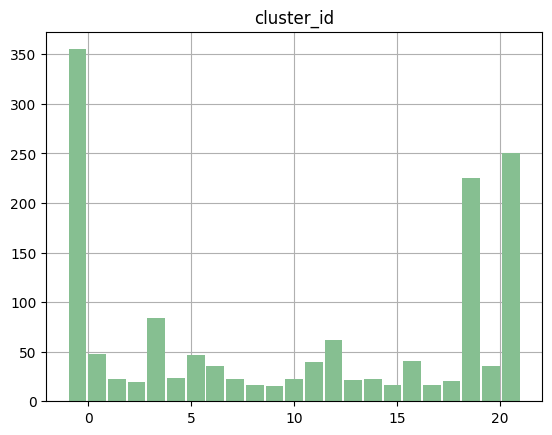

In [6]:
add_cluster_id_attribute(listings)
uniques = listings["cluster_id"].nunique()

hist = listings.hist(bins=uniques, column="cluster_id", color="#86bf91", zorder=2, rwidth=0.9)

Duża liczba wartości **-1** oznaczających szum reprezentuje obiekty, które nie są na tyle blisko siebie, aby można było je połączyć w region. Sztuczne próby zmniejszania szumu skutkowałyby bardziej rozmytymi wynikami klasteryzacji, a w rezultacie gorszymi wynikami całego modelu.

#### *property_type* i *room_type*

In [7]:
listings["property_type"].isna().sum()

np.int64(0)

In [8]:
listings["property_type"].value_counts()

property_type
Entire rental unit                    948
Entire condo                          300
Private room in rental unit            39
Entire home                            32
Entire serviced apartment              32
Room in aparthotel                     20
Room in hotel                          19
Entire loft                            11
Private room in condo                  10
Room in boutique hotel                  7
Room in serviced apartment              6
Private room in home                    5
Private room in serviced apartment      4
Entire villa                            4
Private room in guest suite             4
Private room in guesthouse              3
Entire townhouse                        3
Entire guesthouse                       2
Shared room in hostel                   2
Tiny home                               1
Private room in hostel                  1
Entire guest suite                      1
Camper/RV                               1
Shared room in condo

W celu ograniczenia szumu wynikającego z wielu wartości w kolumnie property type, wartości zostały zgeneralizowane do kilku podstawowych kategorii. Pondato został dodany nowy atrybut (*is_luxury*), który wskazuje czy dane lokum jest luksusowe. Taki atrybut może być silnie skorelowany z ceną.

In [9]:
add_is_luxury_attribute(listings)
listings["is_luxury"].value_counts()

is_luxury
0    1436
1      22
Name: count, dtype: Int64

<Axes: ylabel='count'>

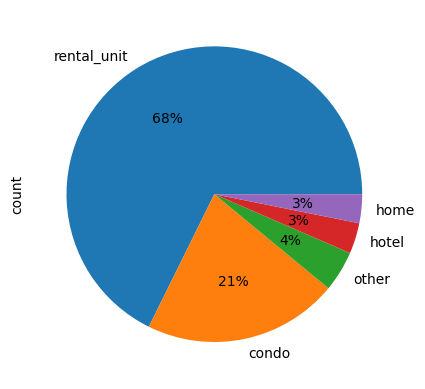

In [10]:
aggregate_property_type(listings)
listings["property_type"].value_counts().plot(kind="pie", autopct="%1.0f%%")

Atrybut *room_type* pozostaje bez zmian, jest już wystarczająco dobrze podzielony na podgrupy. 

In [11]:
listings["room_type"].isna().sum()

np.int64(0)

In [12]:
listings["room_type"].value_counts()

room_type
Entire home/apt    1347
Private room         95
Hotel room           13
Shared room           3
Name: count, dtype: int64

#### *bathrooms_text* i *bathrooms*

Puste wartości w *bathrooms* zostały uzupełnione biorąc dane z *bathrooms_text* - tam braków jest zdecydowanie mniej. Ponadto dodano nowy atrybut *is_bathroom_shared*, który został wyłuskany z tekstu. Po przetworzeniu danych w *bathroom_text* ten atrybut może zostać całkowicie usunięty, nie niesie żadnej nowej informacji.

In [13]:
print(listings["bathrooms_text"].isna().sum())
print(listings["bathrooms"].isna().sum())

2
89


In [14]:
fill_bathrooms_values_from_text(listings)
print(listings["bathrooms_text"].isna().sum())
print(listings["bathrooms"].isna().sum())

2
1


In [15]:
add_is_bathroom_shared_attribute(listings)
listings["is_bathroom_shared"].value_counts()

is_bathroom_shared
0    1411
1      45
Name: count, dtype: Int64

#### *amenities*

In [16]:
listings["amenities"].isna().sum()

np.int64(0)

In [17]:
listings["amenities"].head(10)

0    ["Host greets you", "Coffee maker: Keurig coff...
1    ["Luggage dropoff allowed", "Dishes and silver...
2    ["Host greets you", "Coffee", "Dishes and silv...
3    ["Coffee", "Dishes and silverware", "Cleaning ...
4    ["Host greets you", "Coffee", "Dishes and silv...
5    ["Host greets you", "Coffee", "Dishes and silv...
6    ["Dishes and silverware", "Hair dryer", "Refri...
7    ["Dishes and silverware", "Toaster", "Exercise...
8    ["Host greets you", "Dishes and silverware", "...
9    ["Coffee maker: drip coffee maker, espresso ma...
Name: amenities, dtype: object

In [18]:
from src.amenities_correlation import get_amenities_counter

counter = get_amenities_counter(listings)
unique = [a for a, _ in counter.items()]
print(f'Unique amenities: {len(unique)}')

Unique amenities: 882


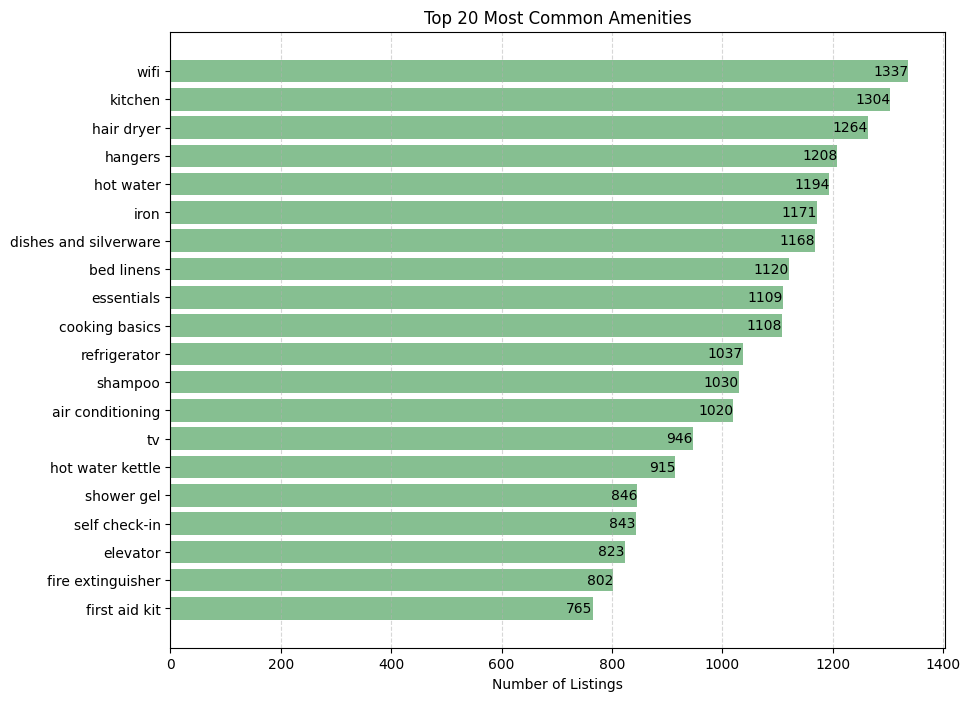

In [19]:
top_20 = counter.most_common(20)
amenities, counts = zip(*top_20)

plt.figure(figsize=(10,8))
bars = plt.barh(amenities[::-1], counts[::-1], color="#86bf91")
for bar in bars:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(width, y, str(width),  va="center", ha="right")
plt.grid(axis="x", linestyle="--", alpha=0.5)
plt.xlabel("Number of Listings")
plt.title("Top 20 Most Common Amenities")
plt.show()

Z uwagi na bardzo dużą liczbę unikalnych udogodnień zostanie wybranych 10, które:
- wyglądają wymiernie (ocena subiektywna);
- mają dużą korelację Pearsona z kolumną price;
- występują w minimum 50 obiektach.

In [20]:
from src.amenities_correlation import *
from src.transformations.target import *

converted_target = convert_price_to_number(target)

amenities_correlation_df = calc_amenities_correlation(listings.copy(), converted_target, min_freq=50)
amenities_mutual_info_df = calc_amenities_mutual_info(listings.copy(), converted_target, min_freq=50)["mutual_info"]

merged = (
    amenities_correlation_df.rename("pearson")
    .to_frame()
    .join(amenities_mutual_info_df.rename("mutual_info"), how="inner")
    .sort_values("pearson", ascending=False)
)

merged.head(n=15)

,pearson,mutual_info
dishwasher,0.187656,0.045614
high chair,0.179205,0.020410
toaster,0.176799,0.012228
oven,0.172354,0.040578
pack ’n play/travel crib,0.151580,0.013764
iron,0.145813,0.021600
free dryer – in unit,0.143109,0.015457
crib,0.142927,0.014010
kitchen,0.142021,0.023109
crib - available upon request,0.134997,0.002446


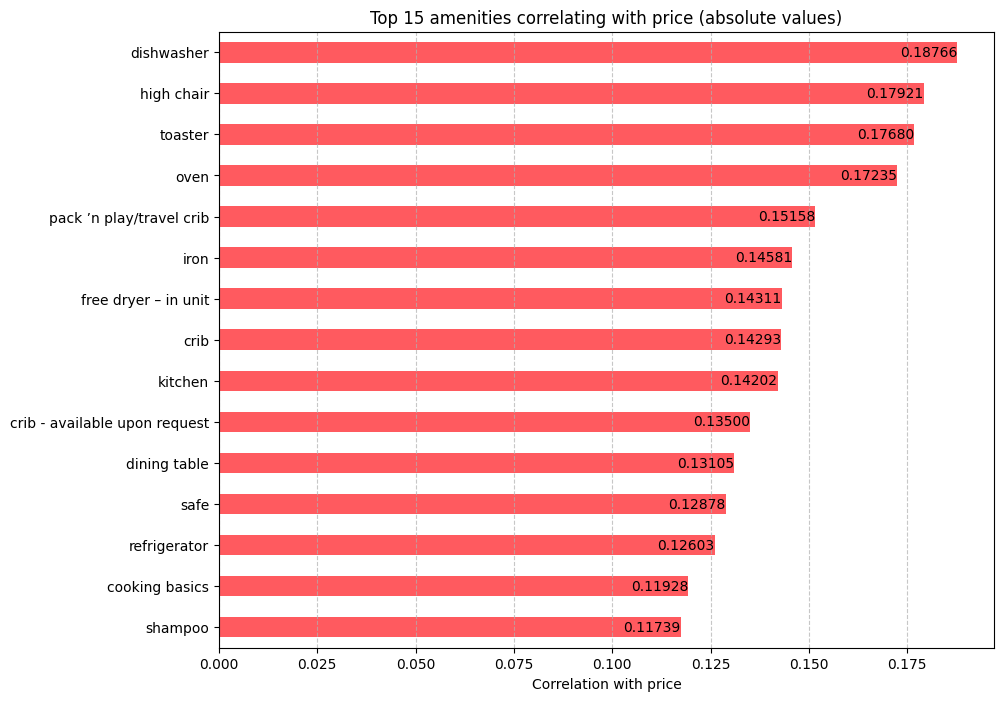

In [21]:
amenities_correlation_df = amenities_correlation_df.abs()

top_15 = amenities_correlation_df.sort_values(ascending=False).head(15)
ax = top_15.sort_values(ascending=True).plot(
    kind='barh',
    figsize=(10, 8),
    color='#FF5A5F',
    title='Top 15 amenities correlating with price (absolute values)'
)
for bar in ax.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    plt.text(width, y, f"{width:.5f}",  va="center", ha="right")
plt.xlabel('Correlation with price')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

Finalnie wybrane udogodnienia to:

In [22]:
from src.transformations.features import AMENITIES
AMENITIES

['dishwasher',
 'iron',
 'toaster',
 'oven',
 'kitchen',
 'microwave',
 'crib',
 'dining table',
 'Free dryer – In unit',
 'Pack ’n play/Travel crib']

Zostaną one zakodowane binarnie

In [23]:
encode_amenities_binary(listings, AMENITIES)
filtered = listings.filter(like="amenity")
filtered.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Empty DataFrame


Pondato zostanie dodana jeden atrybut, mówiący o tym, ile w danym lokum jest wszystkich udogodnień.

In [24]:
add_amenity_count_attribute(listings)
listings["amenity_count"].head()

0    54
1    35
2    45
3    42
4    48
Name: amenity_count, dtype: int64

#### *description* i *neighborhood_overview*
W przypadku kolumn zawierających opisy tekstowe zostanie wyznaczonych ich sentyment. Często opisy zawierają kluczowe informacje dotyczące standardu mieszkania czy też atrakcyjności okolicy, których nie da się uwzględnić w innych atrybutach. Przed wyliczaniem atrybutu dane tekstowe są czyszczone z tagów html. Wartości puste zostaną później uzupełnione w pipelinie ml. 

In [25]:
listings["description"].isna().sum()

np.int64(25)

In [26]:
listings["description"].head()

0    PANORMOU METRO STASION<br /><br />5 minut from...
1                                                  NaN
2    One bedroom apt with large windows overlooking...
3    Ground Floor 50sqm Vintage Style Apartment w/e...
4    This colorful, spacious and clean apt is locat...
Name: description, dtype: object

In [27]:
convert_description_to_sentiment(listings)
listings["description_sentiment"].describe()

count    1433.000000
mean        0.261972
std         0.153664
min        -0.300000
25%         0.161111
50%         0.262500
75%         0.360119
max         0.905556
Name: description_sentiment, dtype: float64

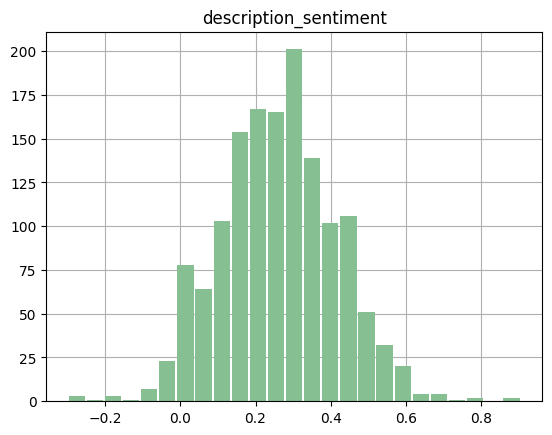

In [28]:
hist = listings.hist(bins=25, column="description_sentiment", color="#86bf91", zorder=2, rwidth=0.9)

In [29]:
listings["neighborhood_overview"].isna().sum()

np.int64(732)

In [30]:
convert_neighborhood_overview_to_sentiment(listings)
listings["neighborhood_overview_sentiment"].describe()

count    726.000000
mean       0.206426
std        0.126848
min       -0.250000
25%        0.133682
50%        0.204508
75%        0.279965
max        0.708333
Name: neighborhood_overview_sentiment, dtype: float64

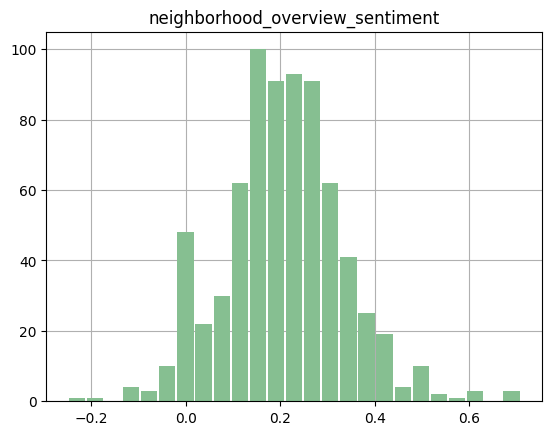

In [31]:
hist = listings.hist(bins=25, column="neighborhood_overview_sentiment", color="#86bf91", zorder=2, rwidth=0.9)

Rozkłady sentymentów okazały się zaskakujące. Wbrew wstępnym założeniom, zgodnie z którymi wystawiający oferty powinni wykazywać tendencję do nadmiernie pozytywnego opisywania swoich lokali, analizowany atrybut charakteryzuje się rozkładem zbliżonym do neutralnego.

#### *host_response_time*
W przypadku tego atrybutu można dostrzec, że ma on natrualny porządek tzn. *within an hour* jest większe/lepsze niż *within a few hours* - na etapie pipelinu ml można stosować kodowanie polegające na przypisaniu kolejnych liczb całkowitych.

In [32]:
listings["host_response_time"].isna().sum()

np.int64(182)

<Axes: ylabel='count'>

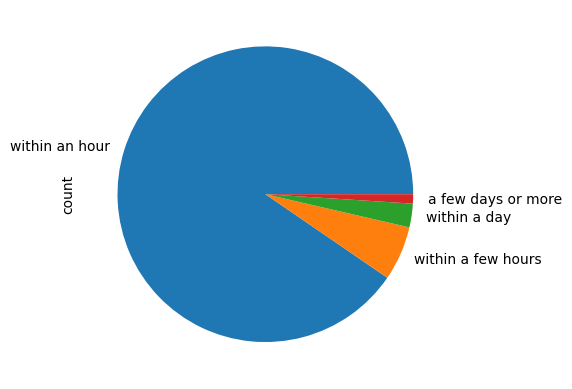

In [33]:
listings["host_response_time"].value_counts().plot(kind="pie")

#### *host_response_rate* i *host_acceptance_rate*
Te atrybuty wymagają zamienienia łańcuchów znaków reperezentujących procenty na liczby zmiennoprzecinkowe.

In [34]:
listings["host_response_rate"].head()

0    100%
1    100%
2    100%
3    100%
4     NaN
Name: host_response_rate, dtype: object

In [35]:
columns_to_convert = ["host_response_rate", "host_acceptance_rate"]
convert_percentage_columns(listings, columns_to_convert)

for col in columns_to_convert:
    print(f"{col} example value: {listings[col][0]}")


host_response_rate example value: 1.0
host_acceptance_rate example value: 1.0


#### *host_is_superhost*, *host_identity_verifed* i *instant_bookable*
Powyższe atrybuty zamiast wartości binarnych są reprezentowane przez *"t" i "f"* - muszą zostać zamienione na wartości liczbowe, żeby model był w stanie je obsłużyć.

In [36]:
listings["host_is_superhost"].head()

0    f
1    t
2    t
3    f
4    f
Name: host_is_superhost, dtype: object

In [37]:
columns_to_convert = ["host_is_superhost", "host_identity_verified", "instant_bookable"]
convert_tf_columns(listings, columns_to_convert)

for col in columns_to_convert:
    print(f"{col} example value: {listings[col][0]}")

host_is_superhost example value: 0
host_identity_verified example value: 1
instant_bookable example value: 0


#### Przegląd atrybutów z *sessions*

In [38]:
from src.transformations.sessions import *

sessions = pd.read_csv("../data/raw/sessions.csv")
sessions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 976183 entries, 0 to 976182
Data columns (total 7 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   action            976183 non-null  object 
 1   user_id           976183 non-null  int64  
 2   timestamp         976183 non-null  object 
 3   listing_id        904250 non-null  float64
 4   booking_date      71933 non-null   object 
 5   booking_duration  71933 non-null   float64
 6   booking_id        74853 non-null   object 
dtypes: float64(2), int64(1), object(4)
memory usage: 52.1+ MB


#### Wybór atrybutów 
Do utworzenia nowych, zagregowanych kolumną posłużą wszystkie atrybuty. Nowe kolumnę będą reprezentowały zachowanie użytkowników mogące wskazywać na realny popyt, który powinien mieć wpływ na cenę. (później zostanie przeprowadzona analiza wtórna, aby ewentualnie wykluczyć zbędnie utworzone kolumny)

Lista zastosowanych transformacji znajduje się w *transformations/sessions.py*.

#### Czyszczenie wstępne
- *action* jako kolumna decyzyjna

In [39]:
sessions["action"].value_counts()

action
view_listing       829397
browse_listings     71933
book_listing        71933
cancel_booking       2920
Name: count, dtype: int64

Rekordów, dla których akcja to *browse_listings*, nie da się połączyć z konkretnymi *listing_id*, dlatego zostaną one odrzucone. 

In [40]:
drop_browse_listings(sessions)
sessions["action"].value_counts()

action
view_listing       829397
browse_listings     71933
book_listing        71933
cancel_booking       2920
Name: count, dtype: int64

- rekordy starsze niż 1 rok

Sytuacja na rynku wynajmu krótkoterminowego jest bardzo dynamiczna, dlatego aby ograniczyć dryf danych oraz ich zaszumienie, na wstępnie odrzucone zostaną rekordy starsze niż **1 rok**. 

In [41]:
convert_timestamps_to_dates(sessions)
sessions["timestamp"].max()

Timestamp('2024-12-02 17:14:31.519819')

In [42]:
drop_records_older_than_one_year(sessions)
sessions["action"].value_counts()

action
view_listing       133834
book_listing        11553
browse_listings     11537
cancel_booking        579
Name: count, dtype: int64

- rozkład danych w ostatnim roku

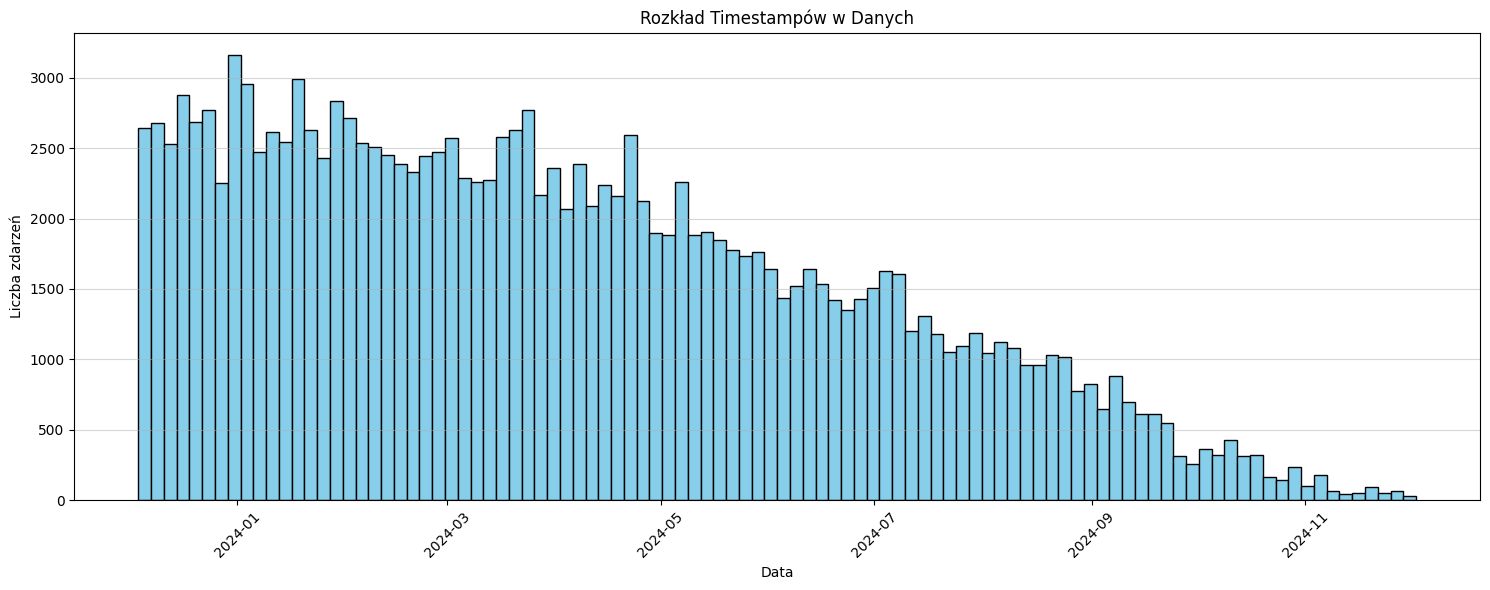

In [43]:
sessions["timestamp"] = pd.to_datetime(sessions["timestamp"], errors="coerce")
valid_dates = sessions["timestamp"].dropna()

plt.figure(figsize=(15, 6))

plt.hist(valid_dates, bins=100, color='skyblue', edgecolor='black')

plt.title("Rozkład Timestampów w Danych")
plt.xlabel("Data")
plt.ylabel("Liczba zdarzeń")
plt.grid(axis='y', alpha=0.5)

plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Ze względu na znaczną dysproporcję w ilości danych między poszczególnymi miesiącami, wszystkie cechy zostaną zagregowane w ujęciu **rocznym**.

#### *views_ltm*

Liczba wyświetleń oferty w ostatnim roku. Kolumna świadcząca o popycie (tylko rekordy, dla których *action* == *view_listing*)

In [44]:
listings_stats = get_views_last(sessions)
listings_stats.head()

,listing_id,listing_views_ltm
0,9.758196e+17,106
1,2.131486e+07,85
2,4.007470e+07,116
3,6.685025e+17,95
4,1.113140e+18,83


In [45]:
print(f'Średnia liczba odsłon oferty w ciągu ostatniego roku: {listings_stats["listing_views_ltm"].mean():.2f}')

Średnia liczba odsłon oferty w ciągu ostatniego roku: 91.79


#### *unique_viewers*

Liczba unikalnych oglądających danej oferty. Służy wykryciu sytuacji, gdy ograniczona ilość użytkowników produkuje wiele "pustych" wyświetleń.

In [46]:
get_unique_viewers_last(sessions, listings_stats)
listings_stats.head()

,listing_id,listing_views_ltm,unique_viewers_ltm
0,9.758196e+17,106,106
1,2.131486e+07,85,85
2,4.007470e+07,116,115
3,6.685025e+17,95,95
4,1.113140e+18,83,82


In [47]:
print(f'Średnia liczba unikalnych widzów oferty w ciągu ostatniego roku: {listings_stats["unique_viewers_ltm"].mean():.2f}')

Średnia liczba unikalnych widzów oferty w ciągu ostatniego roku: 91.30


#### *conversion_rate* (*bookings* / *views*)

Jaka część wyświetleń przełożyła się na faktyczną rezerwację oferty. Atrybut w zakresie <0, 1>.

In [48]:
get_conversion_rate(sessions, listings_stats)
listings_stats.head()

,listing_id,listing_views_ltm,unique_viewers_ltm,conversion_rate_ltm
0,9.758196e+17,106,106,0.169811
1,2.131486e+07,85,85,0.058824
2,4.007470e+07,116,115,0.344828
3,6.685025e+17,95,95,0.010526
4,1.113140e+18,83,82,0.000000


In [49]:
print(f'Średnia konwersja oferty: {listings_stats["conversion_rate_ltm"].mean():.2f}')

Średnia konwersja oferty: 0.08


#### *average_lead_time*

Średnie wyprzedzenie, z jakim dokonywana była rezerwacja. Wskazuje, czy pobyt był planowany z wyprzedzeniem, czy była to rezerwacja "last minute". W przypadku gdy lokal nie miał żadnej rezerawcji (*conversion_rate* = 0) *avg_lead_time* jest nieokreślone. Dopiero na poziomie pipeline'u ml zostanie imputowane.

In [50]:
get_average_lead_time(sessions, listings_stats)
listings_stats.head()

,listing_id,listing_views_ltm,unique_viewers_ltm,conversion_rate_ltm,average_lead_time
0,9.758196e+17,106,106,0.169811,72.111111
1,2.131486e+07,85,85,0.058824,145.200000
2,4.007470e+07,116,115,0.344828,67.400000
3,6.685025e+17,95,95,0.010526,8.000000
4,1.113140e+18,83,82,0.000000,NaN


In [51]:

print(f'Średni średni czas wyprzedzenia (lead time) oferty: {listings_stats["average_lead_time"].mean():.2f} dni')

Średni średni czas wyprzedzenia (lead time) oferty: 66.92 dni


#### *average_booking_duration*

Średnia liczba dni pojedynczej rezerwacji. Rozróżnia pobyty długoterminowe, od krótkoterminowych. Wartości nieokreślone występują analogicznie jak w przypadku atrybutu *average_lead_time*.

In [52]:
get_average_booking_duration(sessions, listings_stats)
listings_stats.head()

,listing_id,listing_views_ltm,unique_viewers_ltm,conversion_rate_ltm,average_lead_time,average_booking_duration
0,9.758196e+17,106,106,0.169811,72.111111,5.500
1,2.131486e+07,85,85,0.058824,145.200000,4.200
2,4.007470e+07,116,115,0.344828,67.400000,6.675
3,6.685025e+17,95,95,0.010526,8.000000,10.000
4,1.113140e+18,83,82,0.000000,NaN,NaN


In [53]:
print(f'Średnia średnia długość pobytu (booking duration) oferty: {listings_stats["average_booking_duration"].mean():.2f} dni')

Średnia średnia długość pobytu (booking duration) oferty: 6.86 dni


#### Połączenie wszystkich atrybutów w jeden zbiór

Najpierw odrzucimy kolumny, które zostały już przetworzone.

In [54]:
drop = ["bathrooms_text", "description", "neighborhood_overview", "amenities"]
listings.drop(columns=drop, inplace=True)

In [55]:
features = listings.merge(listings_stats, left_on="id", right_on="listing_id", how="left")
drop = ["listing_id", "id"]
features.drop(columns=drop, inplace=True)

In [56]:
features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458 entries, 0 to 1457
Data columns (total 29 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   property_type                    1458 non-null   object 
 1   room_type                        1458 non-null   object 
 2   accommodates                     1458 non-null   int64  
 3   bathrooms                        1457 non-null   float64
 4   bedrooms                         1446 non-null   float64
 5   beds                             1370 non-null   float64
 6   latitude                         1458 non-null   float64
 7   longitude                        1458 non-null   float64
 8   host_response_time               1276 non-null   object 
 9   host_response_rate               1276 non-null   float64
 10  host_acceptance_rate             1370 non-null   float64
 11  host_is_superhost                1385 non-null   Int64  
 12  host_identity_verifi

#### Korelacje i Mutual Info

#### Kolumny numeryczne 

In [57]:
from sklearn.feature_selection import mutual_info_regression

num_columns = [
    "accommodates",
    "bathrooms",
    "bedrooms",
    "beds",
    "amenity_count",
    "latitude",
    "longitude",
    "host_response_rate",
    "host_acceptance_rate",
    "review_scores_rating",
    "number_of_reviews",
    "minimum_nights",
    "maximum_nights",
    "description_sentiment",
    "neighborhood_overview_sentiment",
    "listing_views_ltm",
    "unique_viewers_ltm",
    "conversion_rate_ltm",
    "average_lead_time",
    "average_booking_duration",
]
num_df = features[num_columns]
corr_with_target = num_df.corrwith(converted_target).abs().sort_values()

valid_mask = ~num_df.isna().any(axis=1)
num_df_clean = num_df[valid_mask]
target_clean = converted_target[valid_mask]

mi_scores = mutual_info_regression(num_df_clean, target_clean, random_state=42)
mi_series = pd.Series(mi_scores, index=num_df.columns).sort_values()

result_table = pd.DataFrame({
    'Pearson Correlation': corr_with_target,
    'Mutual Information': mi_series
}).sort_values('Pearson Correlation', ascending=False)
result_table


,Pearson Correlation,Mutual Information
accommodates,0.785636,0.512413
beds,0.610546,0.269863
bedrooms,0.562420,0.280188
bathrooms,0.508959,0.140300
latitude,0.254733,0.252877
amenity_count,0.182607,0.000000
review_scores_rating,0.137145,0.090608
longitude,0.083973,0.121242
average_booking_duration,0.079021,0.023196
average_lead_time,0.050090,0.049714


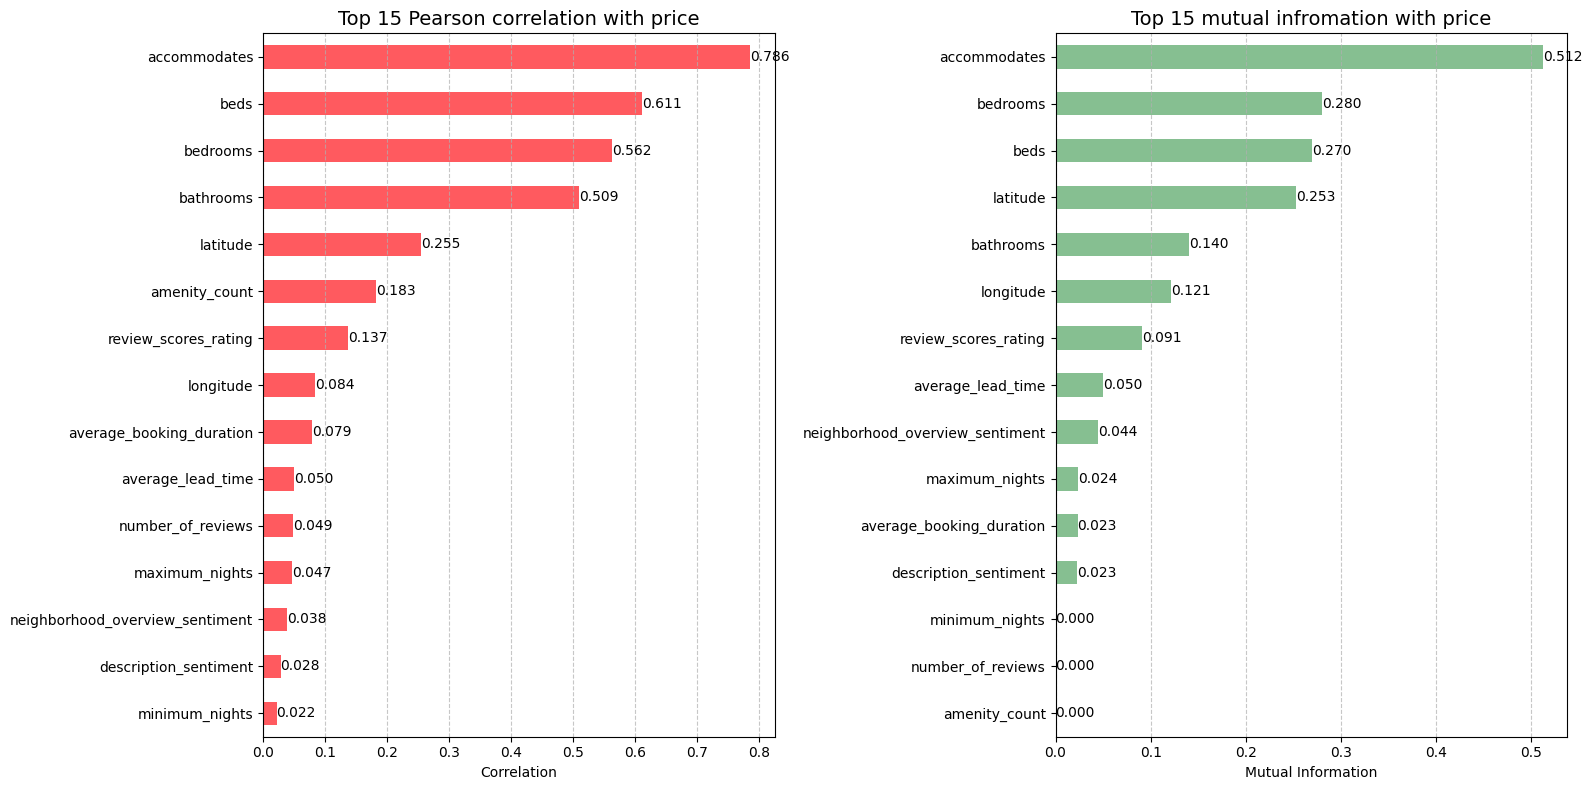

In [58]:
top_15 = result_table.head(15)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))

top_15['Pearson Correlation'].sort_values().plot(
    kind='barh', ax=ax1, color='#FF5A5F'
)
ax1.set_title('Top 15 Pearson correlation with price', fontsize=14)
for bar in ax1.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax1.text(width, y, f"{width:.3f}",  va="center", ha="left")
ax1.set_xlabel('Correlation')
ax1.grid(axis='x', linestyle='--', alpha=0.7)

top_15['Mutual Information'].sort_values().plot(
    kind='barh', ax=ax2, color='#86bf91'
)
for bar in ax2.patches:
    width = bar.get_width()
    y = bar.get_y() + bar.get_height() / 2
    ax2.text(width, y, f"{width:.3f}",  va="center", ha="left")
ax2.set_title('Top 15 mutual infromation with price', fontsize=14)
ax2.set_xlabel('Mutual Information')
ax2.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Atrybuty z *sessions* nie niosą dużej infromacji o cenie. Jeżeli *feature_importances_* dla nich po wytrenowaniu modelu będzie tak samo niskie, zostaną one usunięte.

Text(0.5, 1.0, 'Correlation matrix')

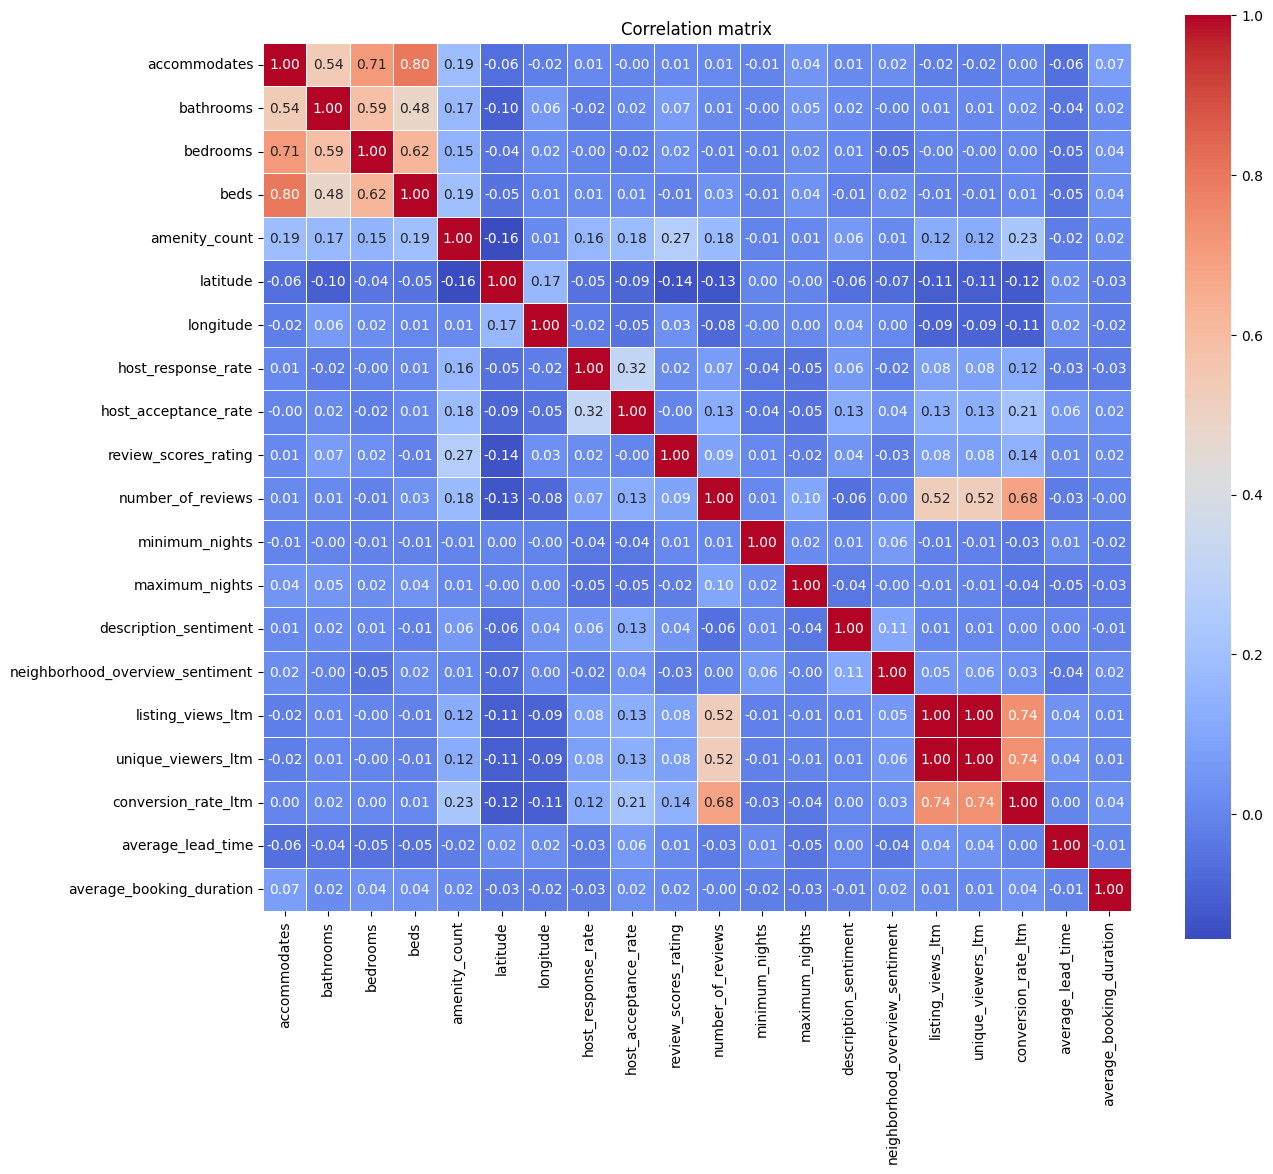

In [59]:
num_df = features[num_columns]
corr_matrix = num_df.corr()

plt.figure(figsize=(14,12))
sns.heatmap(
    corr_matrix,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    cbar=True,
    square=True,
    linewidths=.5
)
plt.title("Correlation matrix")

Większosć atrubutów nie wykazuje wzajemnej korelacji. Atrybuty dotoczyące pojemności kwatery (np. *accommodates*, *beds*, *bedrooms*) wykazują naturalne powiązanie co jest zgodne z oczekiwaniami. Być może niektóre z nich mogą zostać usunięte w finalnej wersji modelu. Niespodziewanie atrybuty *unique_viewers* i *listing_views* są współliniowe (współczynnik korelacji równy 1.0), co oznacza, że każda oferta jest przeglądana przez dokładnie jednego użytkownika. Mimo iż model docelowy - *Random forest* - jest odporny na współliniowość, to model bazowy będący regresją liniową już nie, wobec tego jeden z parametrów należy odrzucić - odrzucona zostanie kolumna *unique_viewers_ltm*.

### Target - *price*

In [60]:
target.isna().sum()

np.int64(0)

In [61]:
target.head()

0     $80.00
1    $250.00
2    $175.00
3    $190.00
4    $210.00
Name: price, dtype: object

In [62]:
target = convert_price_to_number(target)
target.head()

0     80.0
1    250.0
2    175.0
3    190.0
4    210.0
Name: price, dtype: float64

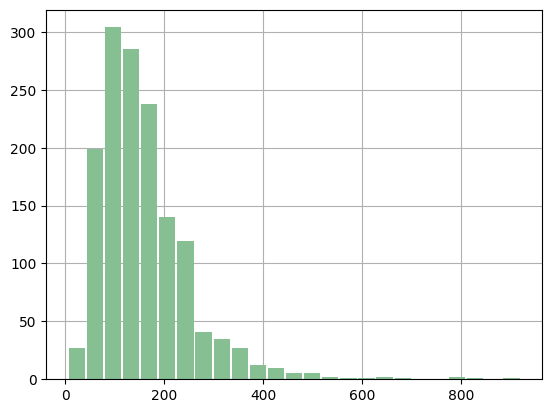

In [63]:
hist = target.hist(bins=25, color="#86bf91", zorder=2, rwidth=0.9)

In [64]:
target.describe()

count    1458.000000
mean      157.537723
std        95.185260
min         5.000000
25%        95.000000
50%       140.000000
75%       195.000000
max       920.000000
Name: price, dtype: float64